# Simulation of a Prescribed Fire policy 

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from prescribed.estimate.simulations import (
    make_model,
    make_predictions_bootstrap,
    simulation_data,
    calculate_benefits,
)
from prescribed.plot import template_plots

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

# Path for data
data_path = "/mnt/sherlock/oak/prescribed_data/"

How can we translate the policy in acres to our model parameters? We have to define the size of the treatments and the number of them to know how many 1 sq-km grids we need 

In [4]:
policy_size = 1_000_000
size_rx = 1_000

print(f"Number of policy 1 sq-km pixels: {policy_size / 247.105}")
print(
    f"If all fires are of {size_rx} acres, then the size is: {size_rx / 247.105} sq-km"
)
print(f"Number of fires in the policy area: {policy_size / size_rx}")

Number of policy 1 sq-km pixels: 4046.8626697153036
If all fires are of 1000 acres, then the size is: 4.046862669715304 sq-km
Number of fires in the policy area: 1000.0


To run simulation we need some intermediary obhjects: 
 1. The actual observed severity for the same space. For this we need to make some data wrangling.  
 2.  What is the possible space of the simulation (i.e. conifer forested areas in California)

In [5]:
# Load DNBR data and save to parquet to make it nicer for DuckDB
dnbr = pd.read_feather(
    os.path.join(data_path, "processed/dnbr_gee/dnbr_long.feather")
).drop(columns=["spatial_ref"], errors="ignore")

# Load MTBS dataset to add year to the DNBR data
mtbs = (
    gpd.read_file(
        os.path.join(
            data_path, "geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
        )
    )
    .to_crs("EPSG:3310")
    .drop(columns=["spatial_ref"], errors="ignore")
)

# Merge it to get years
mtbs["year"] = mtbs.Ig_Date.dt.year

dnbr = dnbr.merge(
    mtbs[["Event_ID", "year"]],
    right_on="Event_ID",
    left_on="event_id",
    how="left",
)
dnbr.drop(columns=["Event_ID"], inplace=True)

# Subset and save to parquet to make it nicer for DuckDB.
# Here we bottom code dnbr to avoid weird and large negative values
dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)

# Because of some dnbr issues (buffered data), we need to remove some of the data
# by using the templates we have from MTBS (remove grids in the buffer). We could
# normally do this by a spatial join, but we have a lot of data and it's slow.
treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
).drop(columns=["spatial_ref"], errors="ignore")

treatments_dnbr = treatments.merge(
    dnbr[["year", "dnbr", "lat", "lon", "grid_id"]],
    left_on=["lat", "lon", "year"],
    right_on=["lat", "lon", "year"],
    how="left",
)

# Clean treatments to only be in Event ID in California and have data
treatments_dnbr = treatments_dnbr[
    (treatments_dnbr.Event_ID.str.startswith("CA"))
    & (~treatments_dnbr.dnbr.isna())
]

# Clean repeated observations for the same fire
treatments_dnbr_clean = treatments_dnbr.groupby(
    ["year", "Event_ID", "Incid_Name", "grid_id", "Ig_Date", "Incid_Type"],
    as_index=False,
).dnbr.max()

treatments_dnbr_clean.to_parquet("../data/dnbr.parquet")


<Axes: xlabel='lon', ylabel='lat'>

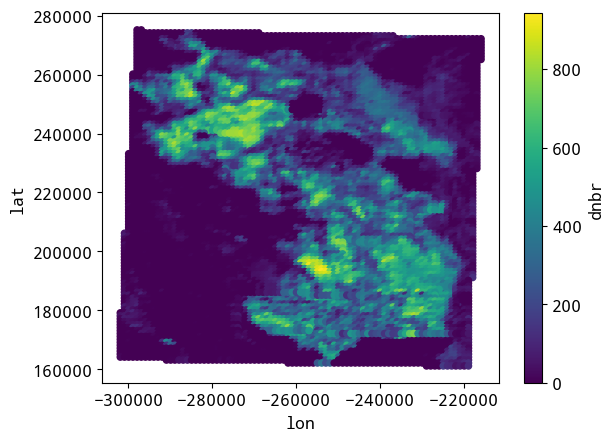

In [5]:
dnbr[dnbr.event_id == "CA3966012280920200817"].plot(
    x="lon", y="lat", kind="scatter", c="dnbr"
)

<Axes: xlabel='lon', ylabel='lat'>

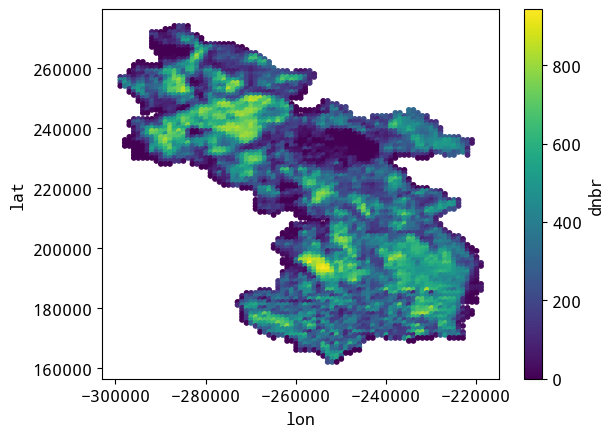

In [6]:
treatments_dnbr[treatments_dnbr.Event_ID == "CA3966012280920200817"].plot(
    x="lon", y="lat", kind="scatter", c="dnbr", s=10
)

### Plot animation of treatment 

Having created the simulations, we can visualize how the treatments are distributed in space and time. This is a simple implementation of an animation that shows the treatment distribution by `year_treat`. Notice we load only the first simulation (`sim == 1`) for the larger policy area (`4000`)

In [6]:
sim_path = "/mnt/sherlock/oak/prescribed_data/processed/simulations"
test_sim = duckdb.query(
    f"""
select *
from '{sim_path}/policy_no_spill_4000_large_4000/*.parquet'
where sim == 1
"""
).to_df()

In [7]:
test_sim

,lat,lon,year,year_treat,grid_id,land_type,coeff,sim
0,287152.596997,-242913.82085,2011,2010,149439,2.0,-49.852447,1
1,357152.596997,-136913.82085,2011,2010,85425,2.0,-112.335970,1
2,232152.596997,-35913.82085,2011,2010,200026,2.0,-81.666960,1
3,273152.596997,-58913.82085,2011,2010,162447,2.0,-123.725278,1
4,98152.596997,-25913.82085,2011,2010,322780,2.0,-83.008166,1
...,...,...,...,...,...,...,...,...
311995,195152.596997,-111913.82085,2022,2021,233842,2.0,-84.948042,1
311996,240152.596997,-144913.82085,2022,2021,192589,2.0,-77.581318,1
311997,109152.596997,-315913.82085,2022,2021,312414,2.0,-62.697053,1
311998,-560847.403003,326086.17915,2022,2021,926776,2.0,-117.781366,1


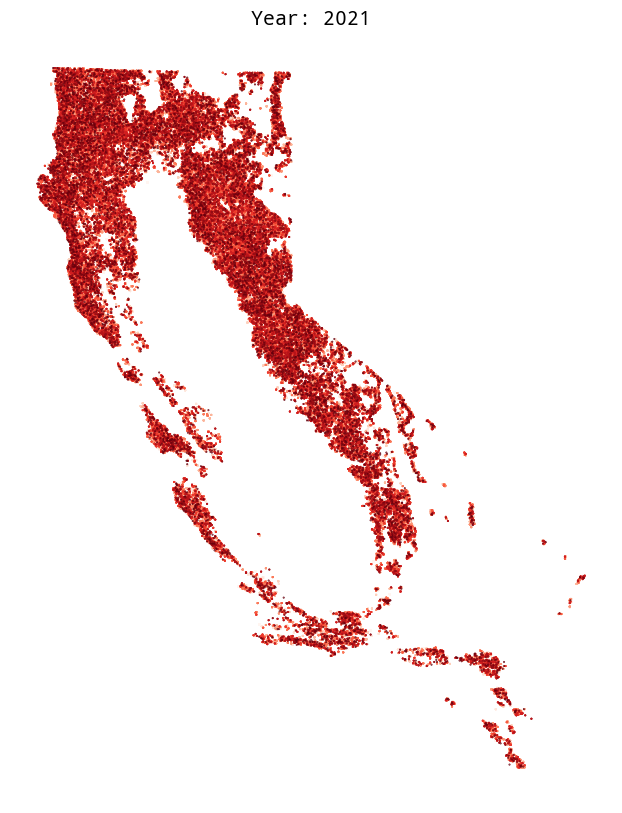

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Transform the DataFrame to a GeoDataFrame
test_sim = gpd.GeoDataFrame(
    test_sim,
    geometry=gpd.points_from_xy(test_sim.lon, test_sim.lat),
    crs="EPSG:3110",
)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Set limits of the plot
# ax.set_xlim(-400_000, -300_000)
# ax.set_ylim(200_000, 400_000)

# Remove axis
ax.axis("off")

# Get unique years
years = sorted(test_sim["year_treat"].dropna().unique())


# Define the update function
def update(year):
    ax.clear()
    # ax.set_xlim(-400_000, -300_000)
    # ax.set_ylim(200_000, 400_000)
    ax.axis("off")
    test_sim[test_sim["year_treat"] <= year].plot(
        ax=ax, column="year_treat", legend=False, markersize=0.2, cmap="Reds"
    )
    ax.set_title(f"Year: {year}")


# Create the animation
ani = FuncAnimation(fig, update, frames=years, repeat=False)

# Save the animation as a GIF or MP4
ani.save("animation.gif", writer="imagemagick", fps=1)
# ani.save('animation.mp4', writer='ffmpeg', fps=1)

# Display the animation
plt.show()

### Read simulations and analize benefits

We use `duckdb` to read all the results from all simulation for a specific policy size. Here we create a large `df` data frame which contains each simulation with its corresponding real value from the `dnbr.parquet` we created at the beginning and then we will be doing different aggregations of the data to check for some insights or possible red flags. 

### Explore $\Delta$ NBR relationship with PM $_{2.5}$ concentrations

In [133]:
smoke_linked_raw = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)


# Select threshold
smoke_linked = smoke_linked_raw[smoke_linked_raw.coverage_threshold == 0.1]

# # Remove outliers from smoke linked data
smoke_linked = smoke_linked[
    (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
    & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
]

# Change year type to avoid problems
smoke_linked["year"] = smoke_linked.year.astype(int)

coefs = make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + I(sum_severity ** 2) + total_pixels + total_days | year",
    bootstrap=True,
    k=999,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

In [82]:
# Estimate boostrap confidence intervals

# Range of severities
range_severity = np.arange(
    smoke_linked["sum_severity"].min(),
    smoke_linked["sum_severity"].max(),
    100,
)

boot_samples = []
coef_arr = np.zeros((1000, 2))
for i in tqdm.tqdm(range(1000), desc="Bootstrappin'"):
    # Sample with replacement

    sample = smoke_linked.sample(frac=1, replace=True)
    sample["year"] = sample.year.astype("int")

    # Estimate the model
    try:
        model = make_model(
            sample,
            formula="sum_contrib ~ sum_severity + I(sum_severity**2) + total_pixels + total_days | year",
        )

        # Get predicted values
        # preds = model.predict(
        #     newdata=pd.DataFrame(
        #         {
        #             "sum_severity": range_severity,
        #             "year": np.array([2010] * len(range_severity)),
        #             #"total_pixels": smoke_linked.total_pixels.mean(),
        #             #"total_days": smoke_linked.total_days.mean(),
        #         }
        #     )
        # )

        # Calculate preds manually
        coefs_ = model.coef()
        coefs_ = coefs_[coefs_.index.str.contains("sum_severity")].values

        # Transform array
        coefs_ = np.expand_dims(coefs_, axis=0)
        coef_arr[i, :] = coefs_

        # Calculate the marginal effect
        preds = (range_severity * coefs_[0, 0]) + (
            (range_severity**2) * coefs_[0, 1]
        )

        boot_samples.append(preds)
    except Exception as e:
        print(e)
        pass

boots = np.vstack(boot_samples)
bounds = np.percentile(boots, [2.5, 0.5, 97.5], axis=0)

Bootstrappin': 100%|██████████| 1000/1000 [02:41<00:00,  6.17it/s]


In [130]:
model.predict(
    newdata=pd.DataFrame(
        {
            "sum_severity": np.array(np.array([60] * 4000).sum()),
            "year": np.array([2010]),
            "total_pixels": np.array([4000]),
            "total_days": np.array([5]),
        }
    )
)

array([316472.35213163])

In [101]:
benefits[benefits.year_treat == 2010]

,year,year_treat,sim,benefit
0,2011,2010,1,77.696250
1,2011,2010,2,991.028591
2,2011,2010,3,111.532129
3,2011,2010,4,704.491165
4,2011,2010,5,0.000000
...,...,...,...,...
55939,2021,2010,995,229349.460940
55940,2021,2010,996,772590.260542
55941,2021,2010,997,50670.804524
55942,2021,2010,998,42721.025177


In [135]:
smoke_linked.year.dtype


dtype('int64')

In [153]:
treat_severity = 60
n_treats = 4000
kwargs = {
    "formula": "sum_contrib ~ sum_severity + I(sum_severity**2) + total_pixels + total_days | year",
    "bootstrap": True,
    "linked_data": smoke_linked,
    "k": 999,
    "predict": True,
}

total_years = benefits.year_treat.unique().shape[0]

new_data = pd.DataFrame(
    {
        "sum_severity": np.repeat(
            np.array(np.array([treat_severity] * n_treats).sum()), total_years
        ),
        "year": benefits.year_treat.unique(),
        "total_pixels": np.repeat(np.array([n_treats]), total_years),
        "total_days": np.repeat(np.array([60]), total_years),
    }
)

costs = make_model(
    new_data=new_data,
    **kwargs,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

In [157]:
new_data

,sum_severity,year,total_pixels,total_days
0,240000,2010,4000,60
1,240000,2011,4000,60
2,240000,2012,4000,60
3,240000,2013,4000,60
4,240000,2014,4000,60
5,240000,2015,4000,60
6,240000,2016,4000,60
7,240000,2017,4000,60
8,240000,2018,4000,60
9,240000,2019,4000,60


In [ ]:
costs_df = pd.DataFrame(costs.T)
costs_df.index = new_data.year
pd.melt(
    costs_df.reset_index(),
    var_name="sim",
    value_name="policy_cost",
    id_vars="year",
)

,year,sim,policy_cost
0,2010,0,782529.422431
1,2011,0,786378.195478
2,2012,0,798418.113456
3,2013,0,787486.397164
4,2014,0,777611.573278
...,...,...,...
10984,2016,998,890957.077581
10985,2017,998,894372.171559
10986,2018,998,962642.854367
10987,2019,998,878554.935271


In [180]:
benefits

,year,year_treat,sim,benefit
0,2011,2010,1,77.696250
1,2011,2010,2,991.028591
2,2011,2010,3,111.532129
3,2011,2010,4,704.491165
4,2011,2010,5,0.000000
...,...,...,...,...
65929,2021,2020,995,227981.987452
65930,2021,2020,996,758754.107816
65931,2021,2020,997,54685.220468
65932,2021,2020,998,46437.728647


In [119]:
total_years = benefits.year_treat.unique().shape[0]

new_data = pd.DataFrame(
    {
        "sum_severity": np.repeat(
            np.array(np.array([treat_severity] * n_treats).sum()), total_years
        ),
        "year": benefits.year_treat.unique(),
        "total_pixels": np.repeat(np.array([n_treats]), total_years),
        "total_days": np.repeat(np.array([10]), total_years),
    }
)
new_data

,sum_severity,year,total_pixels,total_days
0,240000,2010,4000,10
1,240000,2011,4000,10
2,240000,2012,4000,10
3,240000,2013,4000,10
4,240000,2014,4000,10
5,240000,2015,4000,10
6,240000,2016,4000,10
7,240000,2017,4000,10
8,240000,2018,4000,10
9,240000,2019,4000,10


In [188]:
preds = (np.vander(range_severity, 3, increasing=True)[:, 1:] @ coef_arr.T).T

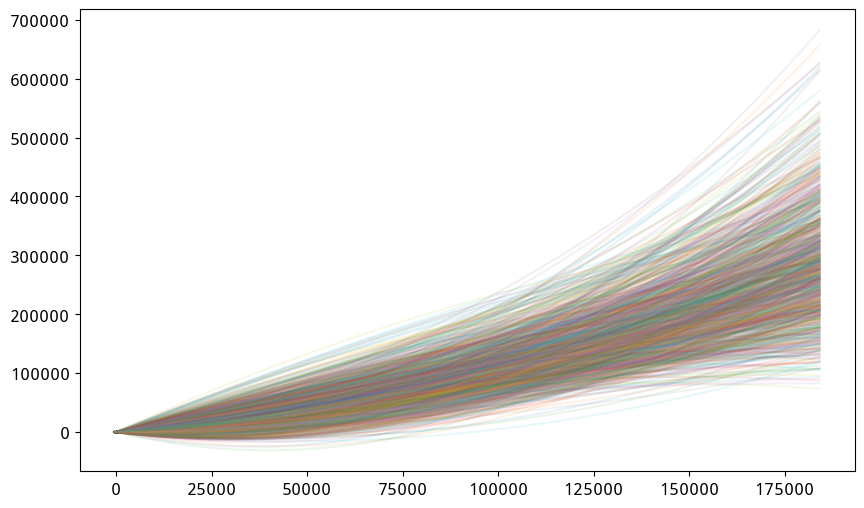

In [189]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(preds.shape[0]):
    ax.plot(range_severity, preds[i], alpha=0.1)

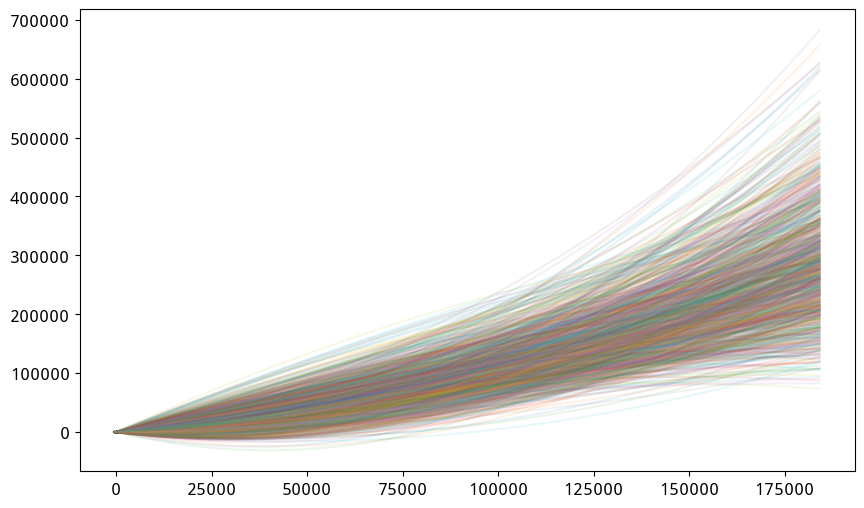

In [190]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(boots.shape[0]):
    ax.plot(range_severity, boots[i], alpha=0.1)

In [23]:
# Range of severities
range_severity = np.arange(
    smoke_linked["sum_severity"].min(),
    smoke_linked["sum_severity"].max(),
    100,
)

range_severity = range_severity.reshape(-1, 1)

# Create an array of range_severity with shape (500, 1000)
range_severity = np.tile(range_severity, (1, 999))

# Calculate the square of each element in range_severity
range_severity_squared = range_severity**2

# Stack the original range_severity and its square to form a new array with shape (500, 2, 1000)
range_severity_stacked = np.stack(
    (range_severity, range_severity_squared), axis=1
)


In [ ]:
# Calculate the marginal effect using vectorized operations
preds = np.einsum("ijk,jk->ik", range_severity_stacked, coefs.T).T
preds.shape


(999, 1845)

In [239]:
# Pivot values to be wide to long in a data frame
preds_df = pd.DataFrame(preds)
preds_df

,0,1,2,3,4,5,6,7,8,9,...,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844
0,-17.429450,-11.070437,-4.606688,1.961799,8.635022,15.412982,22.295679,29.283113,36.375284,43.572191,...,187891.597492,188090.148695,188288.804635,188487.565312,188686.430726,188885.400877,189084.475764,189283.655389,189482.939750,189682.328849
1,-169.448030,-106.989481,-44.260337,18.739401,82.009735,145.550663,209.362187,273.444305,337.797018,402.420326,...,569770.672789,570329.672977,570888.943761,571448.485139,572008.297113,572568.379681,573128.732844,573689.356602,574250.250955,574811.415903
2,-238.700838,-150.499309,-62.170726,26.284911,114.867602,203.577347,292.414146,381.377999,470.468906,559.686866,...,375404.139407,375725.484921,376046.957489,376368.557111,376690.283787,377012.137517,377334.118301,377656.226139,377978.461030,378300.822976
3,107.462941,67.459986,27.745918,-11.679264,-50.815560,-89.662970,-128.221493,-166.491130,-204.471880,-242.163744,...,412809.642559,413299.746040,413790.138407,414280.819661,414771.789801,415263.048828,415754.596741,416246.433540,416738.559225,417230.973797
4,-320.993492,-202.247710,-83.491467,35.275236,154.052400,272.840024,391.638109,510.446653,629.265659,748.095124,...,235179.194245,235317.134877,235455.085969,235593.047522,235731.019535,235869.002009,236006.994943,236144.998337,236283.012192,236421.036507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-330.653482,-208.365799,-86.030183,36.353364,158.784844,281.264256,403.791600,526.366876,648.990084,771.661225,...,304722.396217,304932.639353,305142.930422,305353.269423,305563.656356,305774.091222,305984.574019,306195.104748,306405.683410,306616.310004
996,24.503912,15.293624,6.253420,-2.616703,-11.316742,-19.846699,-28.206573,-36.396365,-44.416074,-52.265700,...,269320.839912,269623.731275,269926.792721,270230.024249,270533.425860,270836.997554,271140.739330,271444.651189,271748.733131,272052.985155
997,-19.493508,-12.360428,-5.134882,2.183129,9.593605,17.096545,24.691951,32.379822,40.160158,48.032958,...,168660.099536,168836.905888,169013.804705,169190.795987,169367.879734,169545.055946,169722.324624,169899.685766,170077.139373,170254.685445
998,83.956093,52.648820,21.631499,-9.095871,-39.533289,-69.680756,-99.538270,-129.105833,-158.383445,-187.371104,...,430535.394159,431036.148264,431537.192322,432038.526331,432540.150292,433042.064204,433544.268068,434046.761884,434549.545652,435052.619371


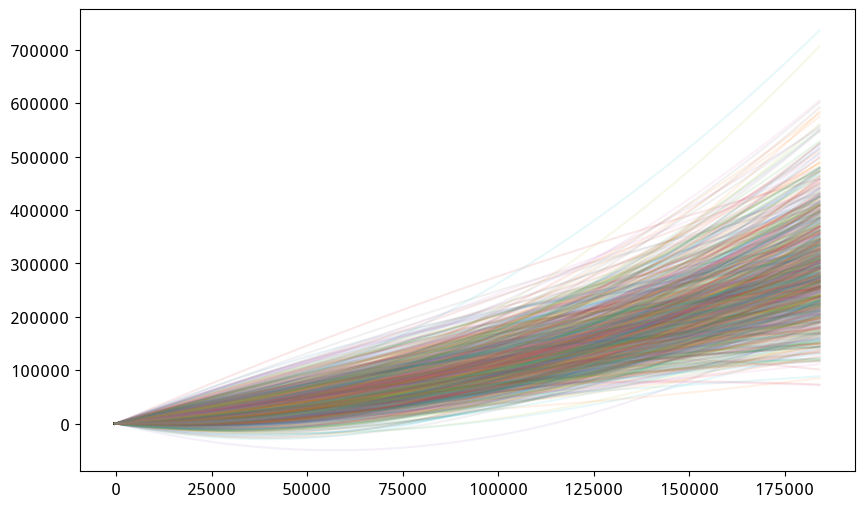

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(preds.shape[0]):
    ax.plot(range_severity[:, 0], preds[i], alpha=0.1)

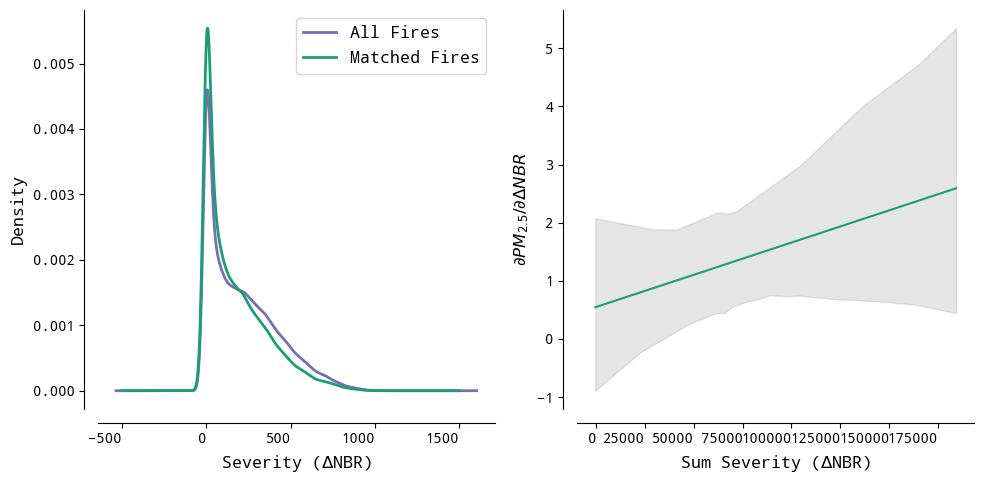

In [14]:
# Plot the predictions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
treatments_dnbr[treatments_dnbr.year > 2006].dnbr.plot.density(
    ax=ax[0], color="#7570b3", linewidth=2
)
treatments_dnbr[
    (treatments_dnbr.year > 2006)
    & (treatments_dnbr.Event_ID.isin(smoke_linked.event_id.tolist()))
].dnbr.plot.density(ax=ax[0], color="#1b9e77", linewidth=2)

# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Add a legend for the two density lines
ax[0].legend(["All Fires", "Matched Fires"], loc="upper right")

# Plot marginal effect of severity on emissions
ax[1].fill_between(
    range_severity,
    bounds[0],
    bounds[1],
    alpha=0.2,
    color="gray",
)

# Plot median prediction as a line
ax[1].plot(
    range_severity,
    np.mean(boots, axis=0),
    color="#1b9e77",
)

# Apply template
template_plots(
    ax[1],
    xlab="Sum Severity ($\Delta$NBR)",
    ylab="$\partial PM_{2.5} / \partial \Delta NBR$",
)


plt.tight_layout()

# Save plot as a vector graphic
plt.savefig("../figs/severity_emissions_link.png", bbox_inches="tight")

#### Calculate total benefits of burning

In [12]:
dnbr_data = duckdb.query("""
with dnbr_data as (
select 
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
)
select event_id, 
       event_name,      
       year,
       sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
""").to_df()

df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT *
    FROM '{sim_path}/policy_no_spill_4000_large_4000/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select 
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
dnbr_event_agg as (
select event_id, 
       event_name,      
       year,
       sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        d.event_name, 
        s.sim,
        s.coeff, 
        d.dnbr,
        case when (d.dnbr + s.coeff) < 0 
                  then 0 
                  else d.dnbr + s.coeff 
        end as sim_benefit
from simulation_data s 
inner join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
), 
benefits_event_agg as (
select event_id,
       year,
       year_treat, 
       event_name,
       sim,
       sum(sim_benefit) as sum_benefit_event
from benefits_grid_simulation
group by event_id, year, event_name, year_treat, sim
),
total_event_benefits as (
select d.event_id,
       d.event_name,
       d.year,
       d.sum_dnbr,
       coalesce(b.year_treat, 0) as year_treat,
       coalesce(b.sim, 0) as sim,
       coalesce(b.sum_benefit_event, 0) as sum_benefit_event,
       coalesce(d.sum_dnbr - b.sum_benefit_event, d.sum_dnbr) as simulated_sum_dnbr
from benefits_event_agg b
INNER JOIN dnbr_event_agg d
on b.event_id = d.event_id and b.year = d.year)
select * from total_event_benefits
""").to_df()

In [ ]:
df_sims = (
    df[["year_treat", "sim"]]
    .drop_duplicates()
    .sort_values(by=["year_treat", "sim"])
    .reset_index(drop=True)
)
dnbr_data_cross = dnbr_data.merge(df_sims, how="cross")

# Clean treatments
dnbr_data_cross = dnbr_data_cross[
    dnbr_data_cross.year > dnbr_data_cross.year_treat
]

In [74]:
simulation_data = dnbr_data_cross.merge(
    df[
        [
            "event_id",
            "year",
            "year_treat",
            "sim",
            "simulated_sum_dnbr",
            "sum_benefit_event",
        ]
    ],
    on=["event_id", "year", "year_treat", "sim"],
    how="left",
)

# Fill nans with 0
simulation_data = simulation_data.assign(
    simulated_sum_dnbr=lambda x: x.simulated_sum_dnbr.fillna(
        simulation_data.sum_dnbr
    ),
    sum_benefit_event=lambda x: x.sum_benefit_event.fillna(0),
)

simulation_data

,event_id,event_name,year,sum_dnbr,year_treat,sim,simulated_sum_dnbr,sum_benefit_event
0,CA3327711653720110721,EAGLE,2011,6423.519277,2010,1,6423.519277,0.000000
1,CA3327711653720110721,EAGLE,2011,6423.519277,2010,2,6423.519277,0.000000
2,CA3327711653720110721,EAGLE,2011,6423.519277,2010,3,6423.519277,0.000000
3,CA3327711653720110721,EAGLE,2011,6423.519277,2010,4,6423.519277,0.000000
4,CA3327711653720110721,EAGLE,2011,6423.519277,2010,5,6423.519277,0.000000
...,...,...,...,...,...,...,...,...
3256735,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,995,30545.814080,719.899835
3256736,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,996,31118.171833,147.542083
3256737,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,997,31197.290705,68.423210
3256738,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,998,31196.571883,69.142032


In [255]:
smoke_linked_raw = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Select threshold
smoke_linked = smoke_linked_raw[smoke_linked_raw.coverage_threshold == 0.6]

# # Remove outliers from smoke linked data
smoke_linked = smoke_linked[
    (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
    & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
]

coefs = make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + I(sum_severity ** 2) + total_pixels + total_days | year",
    bootstrap=True,
    k=999,
)

Bootstrap sampling:   0%|          | 0/999 [00:00<?, ?it/s]

Bootstrap sampling: 100%|██████████| 999/999 [04:29<00:00,  3.70it/s]


In [75]:
simulation_data

,event_id,event_name,year,sum_dnbr,year_treat,sim,simulated_sum_dnbr,sum_benefit_event
0,CA3327711653720110721,EAGLE,2011,6423.519277,2010,1,6423.519277,0.000000
1,CA3327711653720110721,EAGLE,2011,6423.519277,2010,2,6423.519277,0.000000
2,CA3327711653720110721,EAGLE,2011,6423.519277,2010,3,6423.519277,0.000000
3,CA3327711653720110721,EAGLE,2011,6423.519277,2010,4,6423.519277,0.000000
4,CA3327711653720110721,EAGLE,2011,6423.519277,2010,5,6423.519277,0.000000
...,...,...,...,...,...,...,...,...
3256735,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,995,30545.814080,719.899835
3256736,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,996,31118.171833,147.542083
3256737,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,997,31197.290705,68.423210
3256738,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,998,31196.571883,69.142032


In [76]:
# Translate severity benefits into emissions using the coefficients
emissions = make_predictions_bootstrap(
    simulation_data,
    name_var="sum_dnbr",
    out_var="preds_pm",
    coefs=coefs,
    return_pandas=True,
)

simulated_emissions = make_predictions_bootstrap(
    simulation_data,
    name_var="simulated_sum_dnbr",
    out_var="preds_sim_pm",
    coefs=coefs,
    return_pandas=True,
)

# Merge both back to simulated data
simulation_data = simulation_data.merge(
    emissions, on=["event_id", "year_treat", "sim"], how="left"
)

simulation_data = simulation_data.merge(
    simulated_emissions,
    on=["event_id", "year_treat", "sim"],
    how="left",
)

In [77]:
simulation_data

,event_id,event_name,year,sum_dnbr,year_treat,sim,simulated_sum_dnbr,sum_benefit_event,preds_pm,preds_sim_pm
0,CA3327711653720110721,EAGLE,2011,6423.519277,2010,1,6423.519277,0.000000,-138.171246,-138.171246
1,CA3327711653720110721,EAGLE,2011,6423.519277,2010,2,6423.519277,0.000000,10484.194079,10484.194079
2,CA3327711653720110721,EAGLE,2011,6423.519277,2010,3,6423.519277,0.000000,6407.466784,6407.466784
3,CA3327711653720110721,EAGLE,2011,6423.519277,2010,4,6423.519277,0.000000,5003.304934,5003.304934
4,CA3327711653720110721,EAGLE,2011,6423.519277,2010,5,6423.519277,0.000000,-5662.116646,-5662.116646
...,...,...,...,...,...,...,...,...,...,...
3256735,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,995,30545.814080,719.899835,54605.802673,53341.684114
3256736,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,996,31118.171833,147.542083,39769.205029,39563.873741
3256737,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,997,31197.290705,68.423210,16268.660014,16233.101730
3256738,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,998,31196.571883,69.142032,43980.462692,43886.687971


In [78]:
# Remove bad predictions than don't make sense in theory
simulation_data = simulation_data[
    simulation_data.preds_sim_pm <= simulation_data.preds_pm
]

# Calculate benefits for each simulation
simulation_data["benefit"] = (
    simulation_data["preds_pm"] - simulation_data["preds_sim_pm"]
)

/tmp/ipykernel_2876361/3790540808.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation_data["benefit"] = (


In [79]:
simulation_data

,event_id,event_name,year,sum_dnbr,year_treat,sim,simulated_sum_dnbr,sum_benefit_event,preds_pm,preds_sim_pm,benefit
0,CA3327711653720110721,EAGLE,2011,6423.519277,2010,1,6423.519277,0.000000,-138.171246,-138.171246,0.000000
1,CA3327711653720110721,EAGLE,2011,6423.519277,2010,2,6423.519277,0.000000,10484.194079,10484.194079,0.000000
2,CA3327711653720110721,EAGLE,2011,6423.519277,2010,3,6423.519277,0.000000,6407.466784,6407.466784,0.000000
3,CA3327711653720110721,EAGLE,2011,6423.519277,2010,4,6423.519277,0.000000,5003.304934,5003.304934,0.000000
4,CA3327711653720110721,EAGLE,2011,6423.519277,2010,5,6423.519277,0.000000,-5662.116646,-5662.116646,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3256735,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,995,30545.814080,719.899835,54605.802673,53341.684114,1264.118560
3256736,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,996,31118.171833,147.542083,39769.205029,39563.873741,205.331288
3256737,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,997,31197.290705,68.423210,16268.660014,16233.101730,35.558284
3256738,CA4169912147720200722,CALDWELL,2020,31265.713915,2019,998,31196.571883,69.142032,43980.462692,43886.687971,93.774721


In [ ]:
# Aggregate to state level
benefits = simulation_data.groupby(
    ["year", "year_treat", "sim"], as_index=False
)["benefit"].sum()

benefits

,year,year_treat,sim,benefit
0,2011,2010,1,77.696250
1,2011,2010,2,991.028591
2,2011,2010,3,111.532129
3,2011,2010,4,704.491165
4,2011,2010,5,0.000000
...,...,...,...,...
65929,2021,2020,995,227981.987452
65930,2021,2020,996,758754.107816
65931,2021,2020,997,54685.220468
65932,2021,2020,998,46437.728647


In [ ]:
benefits.groupby(["year", "year_treat"]).apply(
    lambda df: 
)

In [ ]:
discount_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

# Now calculate the costs of policy emissions! These are the same across all
# years and simulations.
policy_cost = make_predictions(
    severity=np.array(np.array([60] * 4000).sum()).reshape(
        1,
    ),
    coefs=coefs,
    degree=2,
    uncertainty=False,
)

# Aggregate to state level
benefits = simulation_data.groupby(
    ["year", "year_treat", "sim"], as_index=False
)["benefit"].sum()

# Create costs and merge back to benefits
costs = (
    benefits.groupby(["sim", "year_treat"], as_index=False)
    .apply(
        lambda x: make_predictions(
            severity=np.array(np.array([60] * 4000).sum()).reshape(
                1,
            ),
            coefs=coefs,
            degree=2,
            uncertainty=False,
        )
    )
    .rename(columns={0: "policy_cost"})
)

benefits = benefits.merge(costs, on=["sim", "year_treat"], how="left")

pv_list = []
for discount_rate in discount_rates:
    for idx, df_year in benefits.groupby(["year_treat", "sim"]):
        year, sim = idx

        # Create discount stream for the range of years in the data
        years_policy = df_year.year.unique().shape[0]
        discount_stream = 1 / (1 + discount_rate) ** np.arange(
            1, years_policy + 1
        )

        # Calculate the PV benefits
        pv = np.sum(df_year.benefit.values @ discount_stream)
        ratio = pv / np.unique(df_year.policy_cost)[0]

        pv_list.append(
            pd.DataFrame(
                {
                    "year_treat": [year],
                    "sim": [sim],
                    "pv": [pv],
                    "ratio": [ratio],
                    "discount_rate": [discount_rate],
                }
            )
        )


In [196]:
benefits[(benefits.year_treat == 2016) & (benefits.sim == 1)]

,year,year_treat,sim,benefit,policy_cost
26973,2017,2016,1,43752.498997,599277.054312
33966,2018,2016,1,69860.865854,599277.054312
41958,2019,2016,1,7150.141039,599277.054312
50949,2020,2016,1,278274.963940,599277.054312
60939,2021,2016,1,252340.374671,599277.054312


In [197]:
pv = pd.concat(pv_list)
pv["lag"] = np.abs(pv.year_treat - pv.year_treat.max()) + 1

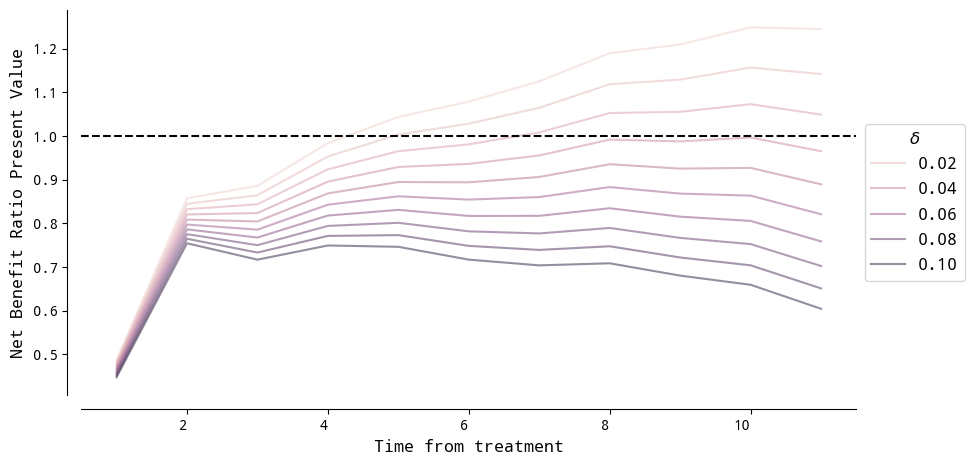

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(
    data=pv.groupby(["year_treat", "discount_rate"]).mean().reset_index(),
    x="lag",
    y="ratio",
    hue="discount_rate",
    alpha=0.5,
    ax=ax,
)

# Add all numbers in the x-axis
# ax.set_xticks(pv.lag.unique())

template_plots(
    ax, xlab="Time from treatment", ylab="Net Benefit Ratio Present Value"
)

# Add a horizontal line at 1
ax.axhline(1, color="black", linestyle="--")

# Move the legend outside the plot and change the title
plt.legend(title=r"$\delta$", loc="center left", bbox_to_anchor=(1, 0.5))

# Save plot
# plt.savefig("../figs/pv_benefits.png", bbox_inches="tight")

In [60]:
np.abs(benefits.year_treat.unique() - 2020) / 10

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ])

In [62]:
benefits[(benefits.lag == 1)].groupby("sim").apply(
    lambda df: np.average(
        df.benefit, weights=np.abs(df.year_treat.unique() - 2020) / 10
    )
)

sim
1      21029.381206
2      21737.165211
3      21252.506163
4      21346.974711
5      21696.786150
           ...     
995    23454.340650
996    24449.209063
997    23329.844680
998    21819.939148
999    23553.837599
Length: 999, dtype: float64

In [63]:
benefits[(benefits.lag == 1)].groupby("sim").apply(
    lambda df: np.mean(df.benefit)
)

sim
1      59354.268771
2      61019.213783
3      59860.839971
4      62049.509977
5      61825.803366
           ...     
995    62298.779634
996    65028.370306
997    63607.109221
998    62215.516557
999    65923.236499
Length: 999, dtype: float64

In [204]:
# An alternative way to calculate PV benefits is to take the average for each period
# of treatment and average on the lagged effect
benefits["lag"] = benefits.year - benefits.year_treat

mean_benefits = benefits.groupby(["lag", "sim"], as_index=False)[
    ["benefit", "policy_cost"]
].mean()

pv_list = []
for discount_rate in discount_rates:
    for sim, sim_df in mean_benefits.groupby("sim"):
        for lag in sim_df.lag.unique():
            # Create discount stream for the range of years in the data
            years_policy = sim_df[sim_df.lag <= lag].shape[0]
            discount_stream = 1 / (1 + discount_rate) ** np.arange(
                1, years_policy + 1
            )

            # Calculate the PV benefits
            pv = np.sum(
                sim_df[sim_df.lag <= lag].benefit.values @ discount_stream
            )
            ratio = pv / np.unique(sim_df.policy_cost)[0]

            pv_list.append(
                pd.DataFrame(
                    {
                        "lag": [lag],
                        "sim": [sim],
                        "pv": [pv],
                        "ratio": [ratio],
                        "discount_rate": [discount_rate],
                    }
                )
            )

In [205]:
mean_benefits

,lag,sim,benefit,policy_cost
0,1,1,71189.939200,599277.054312
1,1,2,73608.421467,599277.054312
2,1,3,72027.841585,599277.054312
3,1,4,73474.983386,599277.054312
4,1,5,74183.153252,599277.054312
...,...,...,...,...
10984,11,995,283266.737045,599277.054312
10985,11,996,295834.589620,599277.054312
10986,11,997,288066.737411,599277.054312
10987,11,998,303135.353559,599277.054312


In [208]:
pv = pd.concat(pv_list)
pv.groupby(["lag", "discount_rate"]).ratio.mean().reset_index()

,lag,discount_rate,ratio
0,1,0.01,0.150732
1,1,0.02,0.149255
2,1,0.03,0.147805
3,1,0.04,0.146384
4,1,0.05,0.144990
...,...,...,...
105,11,0.06,2.227658
106,11,0.07,2.087825
107,11,0.08,1.959723
108,11,0.09,1.842207


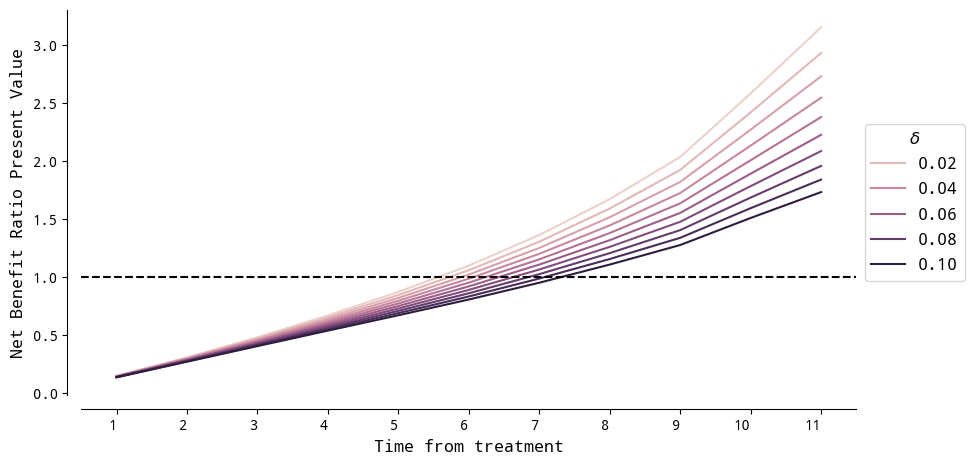

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(
    data=pv.groupby(["lag", "discount_rate"]).ratio.mean().reset_index(),
    x="lag",
    y="ratio",
    hue="discount_rate",
    # alpha=0.5,
    ax=ax,
)

# Add all numbers in the x-axis
ax.set_xticks(pv.lag.unique())

template_plots(
    ax, xlab="Time from treatment", ylab="Net Benefit Ratio Present Value"
)

# Add a horizontal line at 1
ax.axhline(1, color="black", linestyle="--")

# Move the legend outside the plot and change the title
plt.legend(title=r"$\delta$", loc="center left", bbox_to_anchor=(1, 0.5))

# Save plot
plt.savefig("../figs/pv_benefits.png", bbox_inches="tight")

In [201]:
# Load smoke link data
smoke_linked_raw = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Select threshold
smoke_linked = smoke_linked_raw[smoke_linked_raw.coverage_threshold == 0.6]


coefs, model = make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + I(sum_severity ** 2)",
    fe=True,
    return_model=True,
)

In [206]:
make_predictions(
    severity=(
        smoke_linked["sum_severity"].values
        - np.mean(smoke_linked["sum_severity"].values)
    ),
    coefs=coefs,
    uncertainty=False,
    degree=2,
)

0     -58757.161485
1     -46666.289510
2      39045.296546
3     -56541.490616
4     -60337.553789
           ...     
496   -25827.548684
497    38591.259522
498   -56218.210965
499   -37266.061277
500    35314.627831
Length: 501, dtype: float64

Bootstrapping model results/coefficients:   0%|          | 0/999 [00:00<?, ?it/s]

Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:29<00:00, 34.24it/s]


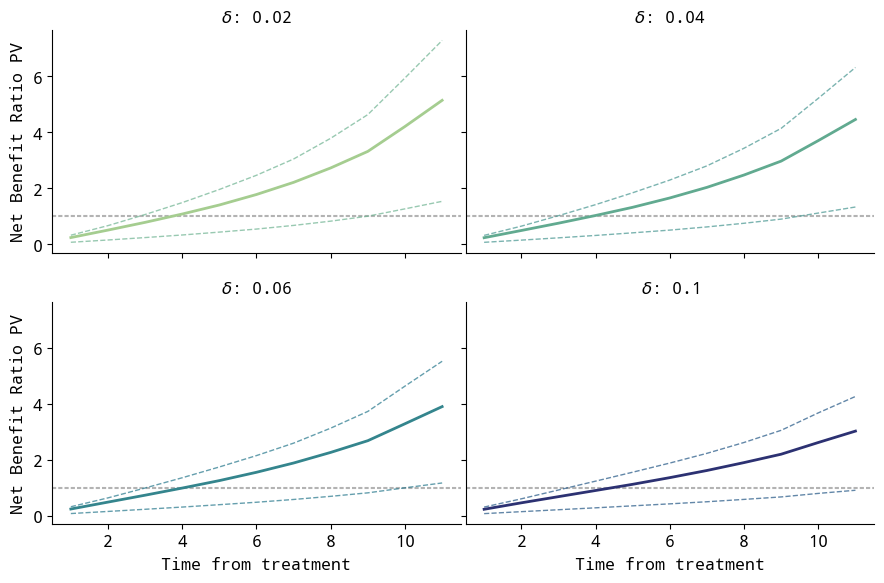

In [296]:
# Set seed numpy
np.random.seed(42)
full_uncertainty = False

# Load smoke link data
smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Select threshold
smoke_linked = smoke_linked[smoke_linked.coverage_threshold == 0.6]

# Avoid prediction errors
smoke_linked["year"] = smoke_linked.year.astype(int)

# Remove outliers from smoke linked data
# smoke_linked = smoke_linked[
#     (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
#     & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
# ]

# coefs = make_model(
#     smoke_linked,
#     formula="sum_contrib ~ sum_severity + I(sum_severity ** 2)  + total_pixels + total_days | year",
#     bootstrap=True,
#     k=999,
# )

benefits, sims = calculate_benefits(
    n_treats=4000,
    path=f"{sim_path}/policy_no_spill_4000_large_4000",
    discount_rates=[0.02, 0.04, 0.06, 0.1],
    treat_severity=60,
    coefs=coefs,
    average_treats=True,
    linked_data=smoke_linked,
    formula="sum_contrib ~ sum_severity + I(sum_severity ** 2) + total_pixels + total_days | year",
    bootstrap=True,
    predict=True,
    k=999,
)

# Define the color palette
palette = sns.color_palette("crest", as_cmap=True)

# remove weird ratios
benefits = benefits.dropna()

# Calculate the means for plotting
mean_benefits = (
    benefits.groupby(["lag", "discount_rate"]).ratio.mean().reset_index()
)


g = sns.relplot(
    data=mean_benefits,
    x="lag",
    y="ratio",
    hue="discount_rate",
    col="discount_rate",
    palette=palette,
    col_wrap=2,
    kind="line",
    height=3,
    aspect=1.5,
    linewidth=2,
    zorder=5,
    legend=False,
    facet_kws={"sharex": True, "sharey": True, "despine": True},
)

(
    g.map(plt.axhline, y=1, color=".7", dashes=(2, 1), zorder=0)
    .set_axis_labels("Time from treatment", "Net Benefit Ratio PV")
    .set_titles(r"$\delta$: {col_name}")
    .tight_layout(w_pad=0)
)

colors = sns.color_palette(
    "crest", n_colors=len(mean_benefits["discount_rate"].unique())
)


if full_uncertainty:
    # Iterate over each subplot to customize further
    for dr, ax in g.axes_dict.items():
        # Plot every year's time series in the background
        sns.lineplot(
            data=benefits.dropna()[benefits.dropna().discount_rate == dr],
            x="lag",
            y="ratio",
            units="sim",
            estimator=None,
            color=".7",
            linewidth=0.3,
            alpha=0.3,
            ax=ax,
        )
else:
    # Plot the 0.025 and 0.975 quantiles for each discount rate and lag
    quantiles = (
        benefits.groupby(["lag", "discount_rate"])
        .ratio.quantile([0.1, 0.9])
        .unstack()
        .reset_index()
    )

    for dr, ax in g.axes_dict.items():
        # Get the quantiles
        q_dr = quantiles[(quantiles.discount_rate == dr)]

        # Plot the quantiles
        ax.plot(
            q_dr.lag,
            q_dr[0.1],
            color=colors[
                list(mean_benefits["discount_rate"].unique()).index(dr)
            ],
            linestyle="--",
            linewidth=1,
            alpha=0.7,
        )
        ax.plot(
            q_dr.lag,
            q_dr[0.9],
            color=colors[
                list(mean_benefits["discount_rate"].unique()).index(dr)
            ],
            linestyle="--",
            linewidth=1,
            alpha=0.7,
        )


# Save plot
plt.savefig("../figs/pv_benefits_pe_avg.png", bbox_inches="tight")

### Try Auto-ML to generate a new function

In [ ]:
benefits.groupby(["lag", "discount_rate"]).ratio.quantile(
    [0.1, 0.9]
).unstack().reset_index()


,lag,discount_rate,0.1,0.9
0,1,0.02,0.071603,0.344886
1,1,0.04,0.070226,0.338254
2,1,0.06,0.068901,0.331872
3,1,0.10,0.066396,0.319804
4,2,0.02,0.146405,0.703340
5,2,0.04,0.142171,0.683147
6,2,0.06,0.138148,0.663963
7,2,0.10,0.130690,0.628350
8,3,0.02,0.226992,1.079569
9,3,0.04,0.218225,1.037577


In [263]:
from prescribed.plot import get_best_poly_fit

# Remove outliers from smoke linked data
smoke_linked = smoke_linked[
    (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
    & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
]

get_best_poly_fit(
    y=smoke_linked[["sum_contrib"]],
    X=smoke_linked[["sum_severity", "total_pixels", "total_days"]],
    degrees=range(1, 10),
)

{'degrees': range(1, 10),
 'rmses': [23230.189076250022,
  22800.496808375952,
  22520.44341031416,
  25686.042164767718,
  25561.032892567393,
  25299.50143933663,
  24533.76776798036,
  24345.84520379484,
  24506.491722497954],
 'best_degree': 3}